In [9]:
from qiskit_aer import Aer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, Operator
import pylatexenc
import sympy

In [10]:
def get_service():
    try:
        # Try to instantiate service (will fail if no token saved or token is invalid)
        return QiskitRuntimeService()
    except Exception as e:
        print(f"Error: {e}")
        # Ask user if they want to renew their local credentials
        renew = input("Your IBM Quantum credentials are invalid or missing. Do you want to renew them? (y/n): ").strip().lower()
        if renew == "y":
            try:
                QiskitRuntimeService.delete_account()
                print("Old local credentials deleted.")
            except Exception as del_e:
                print(f"Could not delete old credentials (maybe none existed): {del_e}")
            token = input("Enter your new IBM Quantum API token: ").strip()
            instance = input("Enter your instance: ").strip()
            QiskitRuntimeService.save_account(token=token, instance=instance, overwrite=True)
            return QiskitRuntimeService()
        else:
            raise RuntimeError("IBM Quantum credentials are required to proceed.")

In [11]:
# Use the function to get the service
service = get_service()

In [12]:
# Now you can use the service as usual
backend = service.backend(name='ibm_brisbane')
print("Number of qubits:", backend.num_qubits)
print("Backend properties:", backend.properties())
print("Backend status:", backend.status())
# Print faulty qubits (if any)
faulty_qubits = []
properties = backend.properties()
for qubit_index, qubit in enumerate(properties.qubits):
    for item in qubit:
        if item.name == 'T1' and item.value is None:
            faulty_qubits.append(qubit_index)
print("Faulty qubits:", faulty_qubits)

Number of qubits: 127
Backend properties: <qiskit_ibm_runtime.models.backend_properties.BackendProperties object at 0x00000252421D3190>
Backend status: <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x0000025240E60490>
Faulty qubits: []


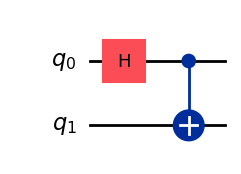

In [13]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
# Add a Hadamard gate to qubit 0
qc.h(0)
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
# this system is made from 2 qubits, so the circuit is 4x4, a kronocker product of 2x2 matrices
# and the circuit is a 4x4 matrix
qc.draw("mpl")

In [14]:
# Tensor products (from IBM Quantum documentation)

zero = Statevector.from_label("0")
one = Statevector.from_label("1")
psi = zero.tensor(one)

plus = Statevector.from_label("+")
minus_i = Statevector.from_label("l")
phi = plus.tensor(minus_i)
display(phi.draw("latex")) # or display((plus ^ minus_i).draw("latex"))

<IPython.core.display.Latex object>

In [15]:
H = Operator.from_label("H")
I = Operator.from_label("I")
X = Operator.from_label("X")
display(H.tensor(I).draw("latex"))
display(H.tensor(I).tensor(X).draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
def create_error_circuit(error_type=None):
    qc = QuantumCircuit(2, 2)
    
    # Apply Hadamard gate to the first qubit
    qc.h(0)
    
    # Apply a controlled-X gate
    qc.cx(0, 1)
    
    # Introduce errors based on the specified error type
    if error_type == 'depolarizing':
        qc.rx(np.random.uniform(0, np.pi), 0)  # Random rotation on qubit 0
        qc.rx(np.random.uniform(0, np.pi), 1)  # Random rotation on qubit 1
    elif error_type == 'bit_flip':
        qc.x(1)  # Bit flip on qubit 1
    elif error_type == 'phase_flip':
        qc.z(1)  # Phase flip on qubit 1
    
    # Measurement
    qc.measure([0, 1], [0, 1])
    
    return qc

def run_circuit(qc):
    backend = Aer.get_backend('qasm_simulator')
    transpiled_circuit = transpile(qc, backend)
    job = execute(transpiled_circuit, backend, shots=1024)
    result = job.result()
    counts = result.get_counts(qc)
    return counts